In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow

In [3]:
flights13_df = pd.read_csv('nycflights13.csv')
flights14_df = pd.read_csv('nycflights14.csv')
flights15_df = pd.read_csv('nycflights15.csv')
flights16_df = pd.read_csv('nycflights16.csv')
flights17_df = pd.read_csv('nycflights17.csv')

In [4]:
flights17_df.tail()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
303743,2017,12,31,2305.0,2058,127.0,157.0,2359,118.0,B6,341,N589JB,EWR,FLL,154.0,1065,20,58,2017-12-31T20:00:00Z
303744,2017,12,31,2307.0,2246,21.0,25.0,1,24.0,B6,75,N337JB,JFK,BTV,48.0,266,22,46,2017-12-31T22:00:00Z
303745,2017,12,31,2310.0,2252,18.0,22.0,5,17.0,B6,647,N197JB,JFK,SYR,43.0,209,22,52,2017-12-31T22:00:00Z
303746,2017,12,31,2317.0,2155,82.0,225.0,121,64.0,B6,616,N988JB,JFK,LAX,345.0,2475,21,55,2017-12-31T21:00:00Z
303747,2017,12,31,2338.0,2246,52.0,36.0,2354,42.0,B6,273,N294JB,JFK,BOS,35.0,187,22,46,2017-12-31T22:00:00Z


In [5]:
allflights_df = pd.concat([flights13_df, flights14_df, flights15_df, flights16_df, flights17_df], ignore_index=True)


In [6]:
allflights_df.astype({'carrier': 'category', 'origin': 'category','dest': 'category'}).dtypes

year                 int64
month                int64
day                  int64
dep_time           float64
sched_dep_time       int64
dep_delay          float64
arr_time           float64
sched_arr_time       int64
arr_delay          float64
carrier           category
flight               int64
tailnum             object
origin            category
dest              category
air_time           float64
distance             int64
hour                 int64
minute               int64
time_hour           object
dtype: object

In [7]:
allflights_df['date'] = pd.to_datetime(allflights_df[['year', 'month', 'day']])
allflights_df['day_of_year'] = allflights_df['date'].dt.dayofyear
allflights_df['month'] = allflights_df['date'].dt.month
allflights_df['day_of_week'] = allflights_df['date'].dt.dayofweek

In [8]:
flights_count_per_day = allflights_df.groupby('date').size().reset_index(name='flight_count')
allflights_df = allflights_df.merge(flights_count_per_day, on='date', how='left')

In [9]:
allflights_df['status'] = np.where(allflights_df['dep_time'].isna() | allflights_df['arr_time'].isna(), 'Cancelled', 'Completed')

cancelled_count_per_date = allflights_df[allflights_df['status'] == 'Cancelled'].groupby('date').size().reset_index(name='cancelled_count')
allflights_df = allflights_df.merge(cancelled_count_per_date, on='date', how='left')

completed_count_per_date = allflights_df[allflights_df['status'] == 'Completed'].groupby('date').size().reset_index(name='completed_count')
allflights_df = allflights_df.merge(completed_count_per_date, on='date', how='left')

In [10]:
allflights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590212 entries, 0 to 1590211
Data columns (total 26 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   year             1590212 non-null  int64         
 1   month            1590212 non-null  int32         
 2   day              1590212 non-null  int64         
 3   dep_time         1546820 non-null  float64       
 4   sched_dep_time   1590212 non-null  int64         
 5   dep_delay        1546816 non-null  float64       
 6   arr_time         1544926 non-null  float64       
 7   sched_arr_time   1590212 non-null  int64         
 8   arr_delay        1541209 non-null  float64       
 9   carrier          1590212 non-null  object        
 10  flight           1590212 non-null  int64         
 11  tailnum          1580620 non-null  object        
 12  origin           1590212 non-null  object        
 13  dest             1590212 non-null  object        
 14  ai

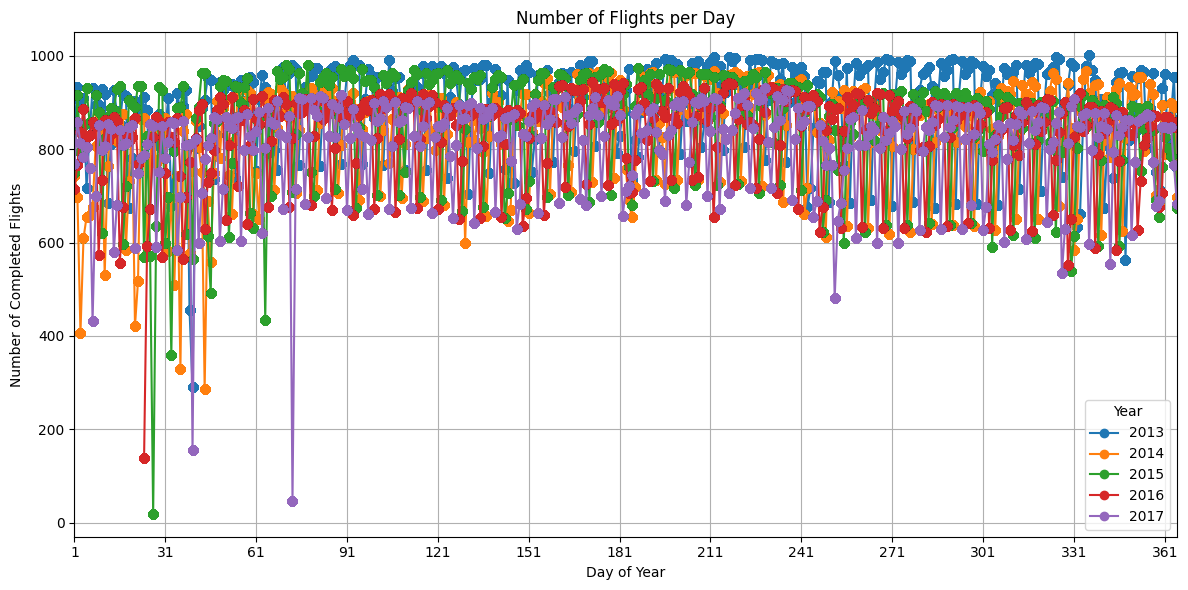

In [11]:
plt.figure(figsize=(12, 6))
for year in allflights_df['year'].unique():
    subset = allflights_df[allflights_df['year'] == year]
    plt.plot(subset['day_of_year'], subset['completed_count'], marker='o', label=str(year))

plt.title('Number of Flights per Day')
plt.xlabel('Day of Year')
plt.ylabel('Number of Completed Flights')
plt.xticks(range(1, 366, 30))
plt.xlim(1, 365)
plt.legend(title='Year')
plt.grid()
plt.tight_layout()
plt.rcParams['savefig.dpi'] = 300
plt.savefig('eachyearplot.png')
plt.show()

In [12]:
holiday_df = pd.read_csv('US Holiday Dates (2004-2021).csv')

In [13]:
holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     342 non-null    object
 1   Holiday  342 non-null    object
 2   WeekDay  342 non-null    object
 3   Month    342 non-null    int64 
 4   Day      342 non-null    int64 
 5   Year     342 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 16.2+ KB


In [14]:
clean_holiday_df = holiday_df[(holiday_df['Year'] >= 2013) & (holiday_df['Year'] <= 2017)]

drop weekends, juneteeth (wasnt a federal holiday until 2021), columbus day is not a major holiday, washingtons birthday not major holiday, eastern easter is not observed in the US, drop mlk jr day - working holiday for most americans

In [15]:
holidays_to_drop = ['Eastern Easter', 'Columbus Day', "Washington's Birthday", "Juneteeth", "Labor Day Weekend", "Martin Luther King, Jr. Day", "Washington's Birthday"]

clean_holiday_df = clean_holiday_df[~clean_holiday_df['Holiday'].isin(holidays_to_drop)]
clean_holiday_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 9 to 339
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     65 non-null     object
 1   Holiday  65 non-null     object
 2   WeekDay  65 non-null     object
 3   Month    65 non-null     int64 
 4   Day      65 non-null     int64 
 5   Year     65 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 3.6+ KB


In [16]:
clean_holiday_df.rename(columns={'Date': 'date'}, inplace=True)
clean_holiday_df.astype({'date': 'datetime64[ns]', 'Holiday': 'category','WeekDay': 'category'}).dtypes
clean_holiday_df['date'] = pd.to_datetime(clean_holiday_df['date'])

In [17]:
holiday_map = dict(zip(clean_holiday_df['date'], clean_holiday_df['Holiday']))
allflights_df['Holiday'] = allflights_df['date'].map(holiday_map)
allflights_df.astype({'Holiday': 'category'}).dtypes
allflights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590212 entries, 0 to 1590211
Data columns (total 27 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   year             1590212 non-null  int64         
 1   month            1590212 non-null  int32         
 2   day              1590212 non-null  int64         
 3   dep_time         1546820 non-null  float64       
 4   sched_dep_time   1590212 non-null  int64         
 5   dep_delay        1546816 non-null  float64       
 6   arr_time         1544926 non-null  float64       
 7   sched_arr_time   1590212 non-null  int64         
 8   arr_delay        1541209 non-null  float64       
 9   carrier          1590212 non-null  object        
 10  flight           1590212 non-null  int64         
 11  tailnum          1580620 non-null  object        
 12  origin           1590212 non-null  object        
 13  dest             1590212 non-null  object        
 14  ai

In [18]:
allflights_df.to_feather("allflights_df.feather") 